In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Attention
from tensorflow.keras.layers import TimeDistributed

In [32]:
NUM_CLASSES = 25
NUM_FRAMES = 100
INPUT_DIM = 2
DATA_DIR = "Data"

In [5]:
classes_name = [
    "Alohomora",
    "Avada Kedavra",
    "Expelliarmus",
    "Expecto Patronum",
    "Lumos",
    "Nox",
    "Wingardium Leviosa",
    "Stupefy",
    "Library Lockus",
    "Professorious",
    "Mosquito Expellio",
    "Plagiarismus Detectio",
    "Basuri Melodico",
    "Giftus Appareus",
    "Manceps Bindio",
    "Ancestor Callium",
    "Dividius Zero",
    "Attendaceus Finalus",
    "Deadlineius Erasum",
    "Stressius",
    "Tempus Forwarius",
    "Tempus Reverisus",
    "Flyhigus Ascendo",
    "Flylowus Descendo",
    "Valentino" 
]

In [6]:
def load_data(data_dir):
    X, y = [], []
    for class_label in range(1, NUM_CLASSES + 1):
        class_dir = os.path.join(data_dir, str(class_label))
        if not os.path.exists(class_dir):
            continue
        for csv_file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, csv_file)
            data = pd.read_csv(file_path)
            if len(data) == NUM_FRAMES:  # Ensure the correct number of frames
                X.append(data[['x', 'y']].values)
                y.append(class_label - 1)  # 0-based index for classes
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)
    return X, y

In [19]:
X,y = load_data(DATA_DIR)

In [20]:
len(X),len(y)

(1418, 1418)

In [21]:
sum = 0
name = os.listdir(DATA_DIR)
for i in name:
    a = len(os.listdir(os.path.join(DATA_DIR,i)))
    sum+=int(a)
sum

1419

In [22]:
type(X),type(y)

(numpy.ndarray, numpy.ndarray)

In [23]:
y = to_categorical(y, NUM_CLASSES)

In [24]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [14]:
model_1 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(NUM_FRAMES, INPUT_DIM)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

2024-12-28 04:38:27.857876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [33]:
model_2 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(NUM_FRAMES, INPUT_DIM))),
    BatchNormalization(),
    Dropout(0.2),
    
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    
    LSTM(64, return_sequences=True),
    Attention(),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(NUM_CLASSES, activation='softmax')
])

In [35]:
# model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=5,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True    # Restore the model weights from the epoch with the best validation loss
)

In [38]:
history_1 = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping_callback]
)

Epoch 1/50


ValueError: Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key]. Received: inputs=(None, 100, 64).

In [31]:
import matplotlib.pyplot as plt

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history_1' is not defined

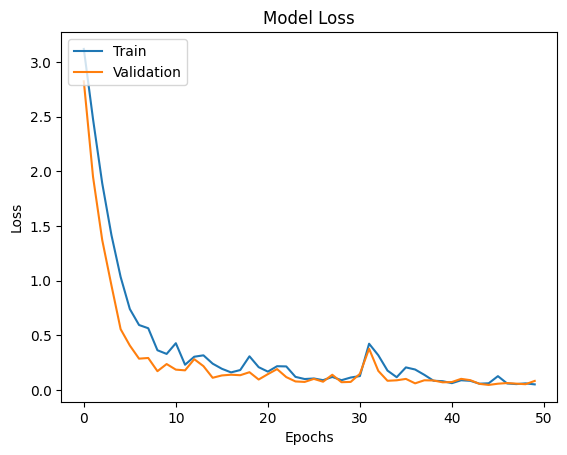

In [40]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
model_1.evaluate(X_val,y_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9923 - loss: 0.0512


[0.08285105973482132, 0.98591548204422]

In [24]:
result = model_1.predict(X_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [36]:
n = 5
print(np.argmax(result[n]))
print(np.argmax(y_val[n]))

23
23


In [41]:
model_1.save('model_1.h5')

In [52]:
# from sklearn.metrics import classification_report

# # Print precision, recall, F1 score for each class
# y_pred_classes = np.argmax(result, axis=1)
# report = classification_report(y_val, y_pred_classes, target_names=classes_name)
# print(report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


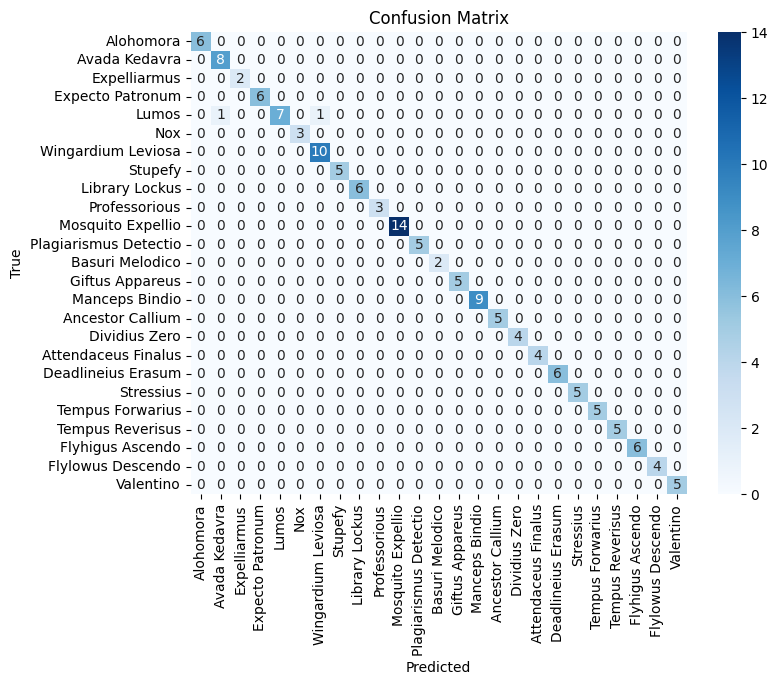

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_val_classes = np.argmax(y_val, axis=1)

y_pred = model_1.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_val_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_name, yticklabels=classes_name)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Model 2 Traning

In [57]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=5,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True    # Restore the model weights from the epoch with the best validation loss
)

In [60]:
# history_2 = model_2.fit((
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=50,
#     batch_size=32
# )